# K-Means Clustering Assignment
This assignment is based on a customer dataset that includes the following features:
* Customer ID
* Age
* Gender
* Annual Income (k$)
* Spending Score (1-100)

Spending Score is a value assigned to customers based on parameters such as their behavior and purchasing data. The dataset and a description can be found at the following link:[https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data)

**Task Description**

You are required to perform a clustering analysis on this dataset using K-Means-based
methods. Specifically, you will:
1. Implement the basic K-Means algorithm with simple cluster initialization.
2. Implement the K-Means++ algorithm.
3. Compare basic K-Means and K-Means++ based on the number of iterations required
to reach convergence.
4. Explore another initialization method for the number of clusters that you will
compare with the two previous.
5. Explore/Implement the Elbow Method to determine the optimal number of clusters.

## **Step 1:** Required Libraries
In this step, we import all the necessary Python libraries:
- `numpy` and `pandas` for data manipulation,
- `matplotlib` and `seaborn` for data visualization,
- `StandardScaler` from `sklearn` for data normalization,
- `PCA` from `sklearn` for optional dimensionality reduction
- `silhouette_score` from `sklearn` to measures how well-separated and well-formed the clusters are.

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SklearnKMeans

## **Step 2:**Loading The Dataset

We load the dataset using `pandas.read_csv()` and preview the first 5 rows.
This dataset includes:
- Customer ID
- Gender
- Age
- Annual Income (k$)
- Spending Score (1-100)


In [113]:
df = pd.read_csv("Mall_Customers.csv")
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## **Step 3:** Exploratory Data Analysis (EDA)
Here we:
- Check the shape of the dataset.
- Identify column data types.
- Verify if there are any missing values.
- Generate summary statistics like mean, std, min, etc.

In [114]:
print("Dataset shape:", df.shape)
n_samples,n_features = df.shape
print('Number of samples:', n_samples)
print('Number of features:', n_features)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
df.describe()

Dataset shape: (200, 5)
Number of samples: 200
Number of features: 5

Data types:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## **Step 4:** Data Preprocessing
We prepare the dataset for clustering by:
- Converting the 'Gender' column into numeric format (0 for Male, 1 for Female).
- Dropping 'CustomerID' as it is irrelevant for clustering since its just an identifier.
- Normalizing all features using `StandardScaler` to ensure equal weight.

In [115]:
# Encode Gender
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Drop CustomerID
data = df.drop(columns=['CustomerID'])
data = data.drop('Gender', axis=1)

# Normalize All Features Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

## **Step 5:** Correlation Matrix

Since most correlation values lie between **-0.33 and 0.058**, indicating **weak or no strong linear relationships** between the features.This means that the features are relatively independent of each other, which is suitable for K-Means clustering.

Hence due to the weak correlations we validate the inclusion of all available features in the clustering model, without the need for dimensionality reduction or feature elimination based on multicollinearity.

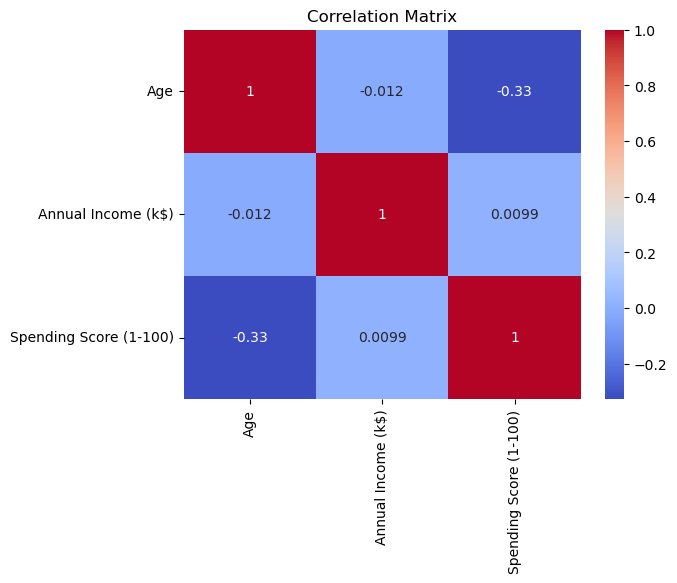

In [116]:
# Compute correlation matrix
corr_matrix = data.corr()

# Plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## **Step 6:** Distribution & Separability
We plot distributions to see how spread out the data is and whether it might form clusters. If certain feature pairs show clear groupings in scatter plots the they are the best candidate.

Clearly we can see that the plot of `Annual Income (k$)` Vs	`Spending Score (1-100)` forms some clusters. Hence we will be using `Annual Income (k$)` and	`Spending Score (1-100)` as our features.

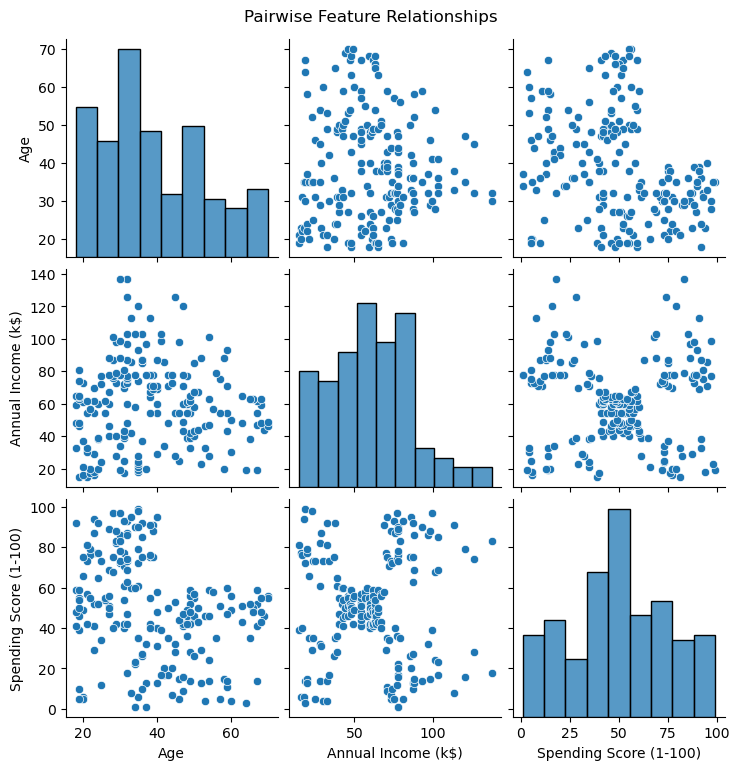

In [117]:
sns.pairplot(data[data.columns])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

From above we conclude that we are going to use `Annual Income (k$)` and	`Spending Score (1-100)` as our features for Kmeans clustering.

In [118]:
column_names = ['Annual Income (k$)', 'Spending Score (1-100)']
column_indices = [data.columns.get_loc(col) for col in column_names]
X_scaled = X_scaled[:,column_indices]

## **Step 7:** Kmeans Implementation
Here we will define all important functions step by step for computing Kmeans

* Compute Distance

In [119]:
# Co mpute Euclidean distance
def distance(c, x):
  return np.sqrt(np.sum((c - x) ** 2))

* Assign Clusters

In [120]:
# Assign Clusters
def assign_clusters(X, centroids):
  labels = np.array([
      np.argmin([distance(c, x) for c in centroids])
      for x in X
  ])
  return labels

* Compute Centroids

In [121]:
# Compute Centroids
def compute_centroids(X, labels, k):
    centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
        else:
            centroid = X[np.random.randint(0, len(X))]
        centroids.append(centroid)
    return np.array(centroids)

* Check For Convergence
It convergece if the centroids doesn't change

In [122]:
# Check For Convergence
#def is_converged(centroids,new_centroids):
 # return np.allclose(centroids, new_centroids)

def is_converged(centroids, new_centroids, tol=1e-4):
  shift = np.linalg.norm(centroids - new_centroids)
  return shift < tol


* Plot The Clusters In 2D
We use PCA for dimention reduction to two for easy visualization.

In [123]:
# Plot The Clusters In 2D
def plot_2D_clusters_with_pca(X, clusters, centroids):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    centroids_reduced = pca.transform(centroids)

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    # Plot clusters
    for i,cluster in enumerate(clusters):
        cluster = np.array(cluster)
        cluster_reduced = pca.transform(cluster)
        ax.scatter(cluster_reduced[:, 0], cluster_reduced[:, 1], color=colors[i % len(colors)], label=f'Cluster {i}')

    # Plot centroids
    ax.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker="x", color="black", linewidth=2)

    plt.title("KMeans Clustering (PCA-reduced to 2D)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.legend()
    plt.show()


* Kmeans Function

In [124]:
# Kmeans Function
def Kmeans(X,K,max_iters=100, initialize_centroids_func=None, random_state=None):

    # Seed
    np.random.seed(random_state)

    # Initialize Centroids
    centroids = initialize_centroids_func(X, K)
    converged = False
    n_iter = 0
    for i in range(max_iters):

        # Assign each point to the nearest centroid
        labels = assign_clusters(X, centroids)

        # Group points by cluster
        clusters = [[] for _ in range(K)]
        for point, label in zip(X, labels):
            clusters[label].append(point)

        # Compute new centroids
        new_centroids = compute_centroids(X, labels, K)

        # Convergence check
        if is_converged(centroids,new_centroids):
            #print(f"Converged at iteration {i+1}")
            converged = True
            break

        centroids = new_centroids
        n_iter+=1

    #if not converged:
        #print(f"Did not converge after {max_iters} iterations")

    return centroids, clusters,n_iter+1

## **Step 8:** Basic K-Means Implementation
We implement K-Means with random initialization and observe cluster assignments for `K=6`.

* **Random Initialzation Of Centroids**

In [125]:
# Random Initialzation Of Centroids
def random_centroids_initialzation(X, K):
    labels = np.random.randint(0, K, size=len(X))
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(K)])
    return centroids

* **Kmeans With Random Initialization**

Number of iterations (Random): 7


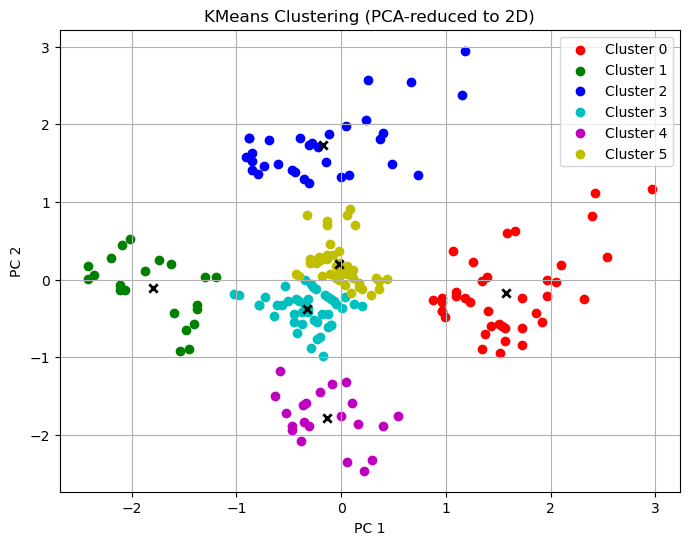

In [126]:
# Kmeans With Random Initialization
centroids,clusters,kmeans_basic_iter = Kmeans(X_scaled,K=6,
                                              max_iters=100,
                                              initialize_centroids_func=random_centroids_initialzation,
                                              random_state = 42)

print(f"Number of iterations (Random): {kmeans_basic_iter}")
plot_2D_clusters_with_pca(X_scaled, clusters, centroids)

## **Step 9:** K-Means++ Initialization Implementation
Now we run K-Means using the improved K-Means++ initialization method, which initializes centroids more efficiently and observe cluster assignments for `K=6`.

**Initialize Centroids using K-Means++:**

   1.1. Choose one data point at random from $X$ as the first centroid.

   1.2. For each data point $x$ in $X$, compute the distance to the nearest existing centroid.

   1.3. Convert these distances into probabilities using the softmax function:

   $$
   p(x_i) = \frac{e^{d(x_i)}}{\sum_j e^{d(x_j)}}
   $$

   1.4. Select the next centroid randomly, using the computed probabilities.

   1.5. Repeat steps 1.2–1.4 until $K$ centroids are selected.


* Softmax  

It will help us in calculating the probabilities.

In [127]:
# Softmax To calaculate Probabilies
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

* **Kmeans++ Initialzation Of Centroids**

In [128]:
# Kmeans++ Initialzation Of Centroids
def kmeans_plusplus_centroids_initialzation(X, K):
  n_samples = X.shape[0]

  centroids = []
  first_centroids = X[np.random.choice(n_samples)]
  centroids.append(first_centroids)

  for i in range(K - 1):
      d = np.array([
          min(distance(c,x) for c in centroids)
          for x in X
      ])
      probabilities = softmax(d)
      new_centroids_index = np.random.choice(n_samples, p=probabilities)
      centroids.append(X[new_centroids_index])

  return np.array(centroids)

Number of iterations (Kmean++): 7


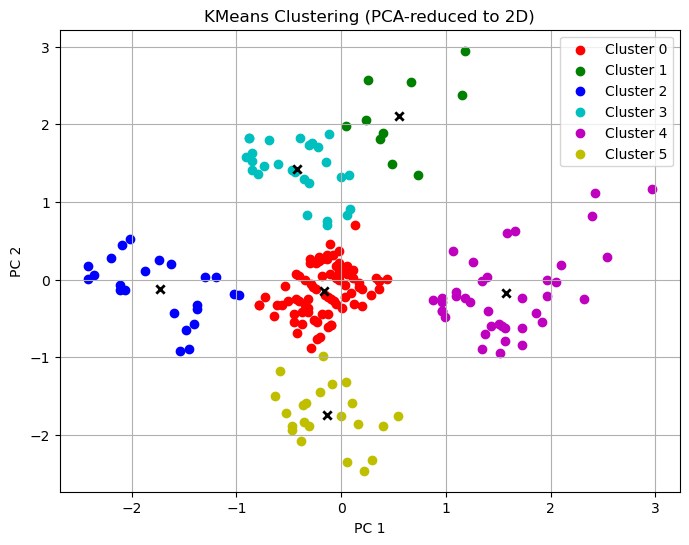

In [129]:
# Kmeans With Kmeans++ Initialzation
centroids,clusters,kmeans_plus_iter = Kmeans(X_scaled,K=6,
                                              max_iters=100,
                                              initialize_centroids_func=kmeans_plusplus_centroids_initialzation,
                                              random_state = 42)

print(f"Number of iterations (Kmean++): {kmeans_plus_iter}")
plot_2D_clusters_with_pca(X_scaled, clusters, centroids)

## **Step 10:** Try Another Initialization Strategy
In adddition to the first two we have another strategy for centroid initilization known as **Forgy Initialization**

This method is one of the faster initialization methods for k-Means. If we choose to have k clusters, the Forgy method chooses any k points from the data at random as the initial points.

* **Forgy Initialzation Of Centroids**

In [130]:
# Forgy Initialzation Of Centroids
def forgy_centroids_initialzation(X, K):
  idx = np.random.choice(len(X),K,replace=False)
  return X[idx]

Number of iterations (Forgy): 5


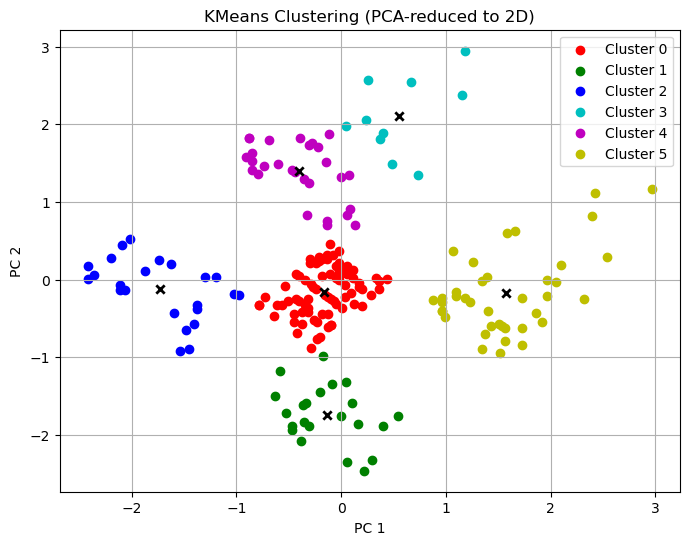

In [131]:
centroids,clusters,kmeans_forgy_iter = Kmeans(X_scaled,K=6,
                                              max_iters=100,
                                              initialize_centroids_func=forgy_centroids_initialzation,
                                              random_state = 42)

print(f"Number of iterations (Forgy): {kmeans_forgy_iter}")
plot_2D_clusters_with_pca(X_scaled, clusters, centroids)

## **Step 11:** Comparison of Random vs KMeans++ vs Forgy Initialization
Here we compare the iterations to convergence across multiple random seeds of the three initialization methods.

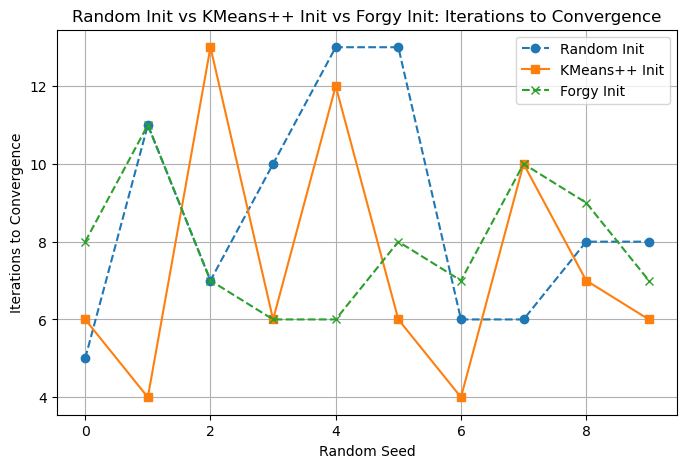

In [132]:
# Compare iterations to convergence across multiple random seeds
seeds = range(10)
k = 6
max_iters = 100

basic_iters = []
plus_iters = []
forgy_iters = []

for seed in seeds:
    # KMeans with random init
    _, _, basic_iter = Kmeans(X_scaled, K=k, max_iters=max_iters,
                              initialize_centroids_func=random_centroids_initialzation,
                              random_state=seed)
    basic_iters.append(basic_iter)

    # KMeans with KMeans++ init
    _, _, plus_iter = Kmeans(X_scaled, K=k, max_iters=max_iters,
                             initialize_centroids_func=kmeans_plusplus_centroids_initialzation,
                             random_state=seed)
    plus_iters.append(plus_iter)

    # KMeans with Forgy init
    _, _, forgy_iter = Kmeans(X_scaled, K=k, max_iters=max_iters,
                             initialize_centroids_func=forgy_centroids_initialzation,
                             random_state=seed)
    forgy_iters.append(forgy_iter)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(seeds, basic_iters, 'o--', label="Random Init")
plt.plot(seeds, plus_iters, 's-', label="KMeans++ Init")
plt.plot(seeds, forgy_iters, 'x--', label="Forgy Init")
plt.xlabel("Random Seed")
plt.ylabel("Iterations to Convergence")
plt.title("Random Init vs KMeans++ Init vs Forgy Init: Iterations to Convergence")
plt.legend()
plt.grid(True)
plt.show()

Method: Random
Iterations: 7
Inertia: 57.2862
Silhouette Score: 0.4236


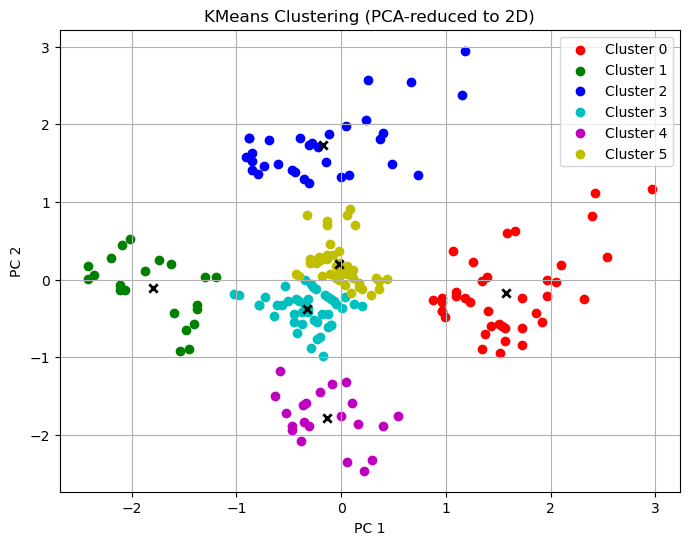

Method: KMeans++
Iterations: 7
Inertia: 55.3758
Silhouette Score: 0.5212


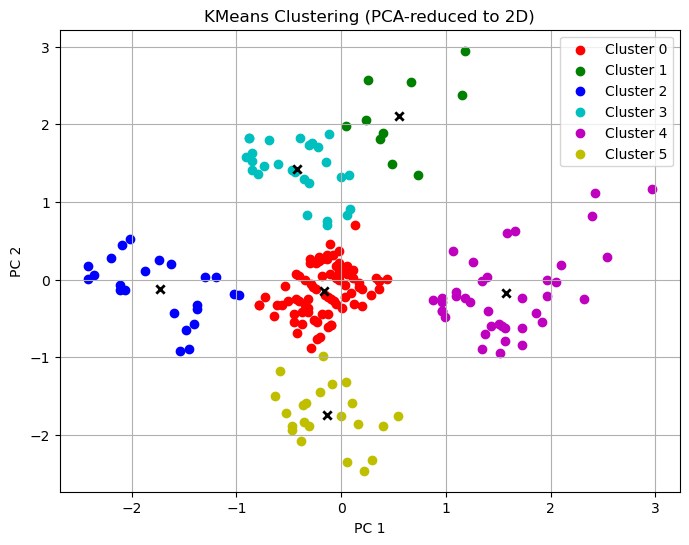

Method: Forgy
Iterations: 5
Inertia: 55.3773
Silhouette Score: 0.5205


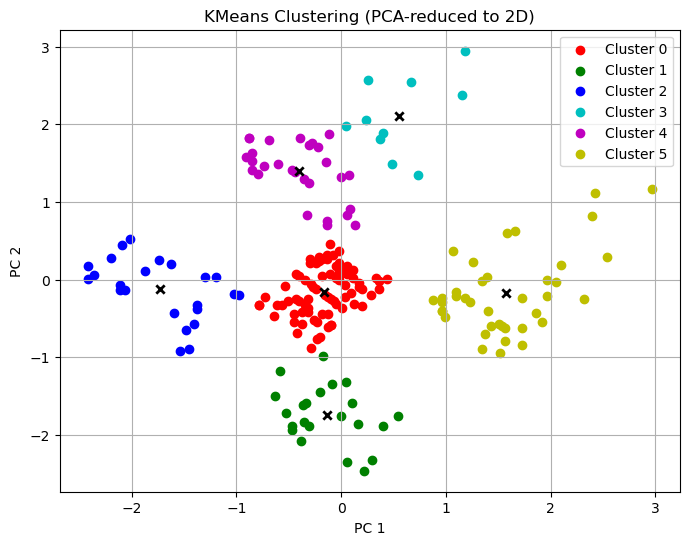

,Method,Iterations,Inertia,Silhouette
0,Random,7,57.286209,0.423589
1,KMeans++,7,55.375816,0.521207
2,Forgy,5,55.377346,0.520461


In [133]:
def compute_inertia(clusters, centroids):
    inertia = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            inertia += np.sum((point - centroids[i]) ** 2)
    return inertia

def compare_kmeans_initializations(X, K=6, random_state=42):
    results = []

    methods = {
        'Random': random_centroids_initialzation,
        'KMeans++': kmeans_plusplus_centroids_initialzation,
        'Forgy': forgy_centroids_initialzation

    }

    for method_name, init_func in methods.items():
        centroids, clusters, n_iter = Kmeans(
            X, K=K, max_iters=100,
            initialize_centroids_func=init_func,
            random_state=random_state
        )

        labels = np.zeros(len(X), dtype=int)
        for cluster_idx, cluster_points in enumerate(clusters):
            for point in cluster_points:
                idx = np.where((X == point).all(axis=1))[0][0]
                labels[idx] = cluster_idx

        inertia = compute_inertia(clusters, centroids)
        silhouette = silhouette_score(X, labels)

        results.append({
            "Method": method_name,
            "Iterations": n_iter,
            "Inertia": inertia,
            "Silhouette": silhouette
        })

        print(f"Method: {method_name}")
        print(f"Iterations: {n_iter}")
        print(f"Inertia: {inertia:.4f}")
        print(f"Silhouette Score: {silhouette:.4f}")
        plot_2D_clusters_with_pca(X, clusters, centroids)

    df_results = pd.DataFrame(results)
    return df_results
compare_kmeans_initializations(X_scaled, K=6, random_state=42)

## **Step 12:** Elbow Method

We'll apply the elbow method by plotting inertia (within-cluster sum of squares(WCSS)) vs. number of clusters.

* Compute Inertia

In [134]:
def compute_inertia(clusters, centroids):
    inertia = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            inertia += np.sum((point - centroids[i]) ** 2)
    return inertia

* Plot Inertia Vs Number of clusters

In [135]:
def plot_elbow_method(X, max_k=10, random_state=None):
    inertias = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        centroids, clusters,n_iter = Kmeans(X,K=k,
                                              max_iters=100,
                                              initialize_centroids_func=kmeans_plusplus_centroids_initialzation,
                                              random_state = random_state)
        inertia = compute_inertia(clusters, centroids)
        inertias.append(inertia)

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia (WCSS)')
    plt.title('Elbow Method For Optimal K')
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()

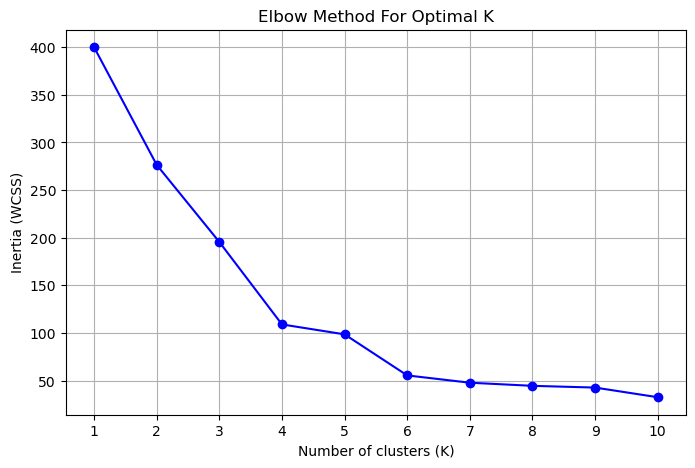

In [136]:
plot_elbow_method(X_scaled, max_k=10, random_state=42)

## **Step 13:**  Silhouette Score Plot for Optimal K Selection

This function evaluates the clustering quality for different values of $K$ using the Silhouette Score, a metric that measures how well-separated and well-formed the clusters are.

A higher Silhouette Score indicates better-defined clusters. The optimal  $K$ is usually the one with the highest score, balancing both compactness and separation of clusters.


In [137]:
def plot_silhouette_scores(X, max_k=10, random_state=None):
    scores = []
    K_range = range(2, max_k + 1)

    for k in K_range:
        centroids, clusters, _ = Kmeans(X,K=k,
                                              max_iters=100,
                                              initialize_centroids_func=kmeans_plusplus_centroids_initialzation,
                                              random_state = random_state)

        labels = np.zeros(len(X), dtype=int)
        for cluster_idx, cluster_points in enumerate(clusters):
            for point in cluster_points:
                point_idx = np.where((X == point).all(axis=1))[0][0]
                labels[point_idx] = cluster_idx

        score = silhouette_score(X, labels)
        scores.append(score)

    plt.figure(figsize=(8,5))
    plt.plot(list(K_range), scores, 'bo-', linewidth=2)
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for Different K")
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()

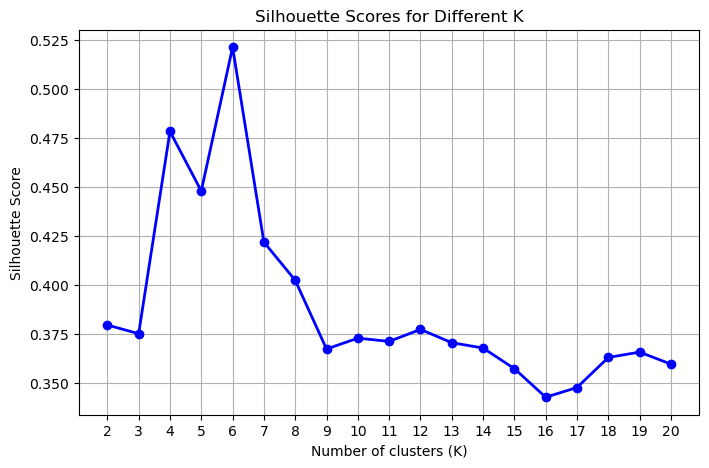

In [138]:
plot_silhouette_scores(X_scaled, max_k=20, random_state=42)

## **Step 14:** Compare The Silhouette Score For Differnt Features Combinations


In [139]:
feature_sets = [
    ['Age', 'Annual Income (k$)'],
    ['Annual Income (k$)', 'Spending Score (1-100)'],
    ['Age', 'Spending Score (1-100)'],
    ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
]

results = []

for features in feature_sets:
    X = df[features].copy()

    x_scaled = StandardScaler().fit_transform(X)

    centroids, clusters, _ = Kmeans(x_scaled, K=6, initialize_centroids_func=kmeans_plusplus_centroids_initialzation,random_state=1234)

    labels = np.zeros(len(x_scaled), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters):
        for point in cluster_points:
            idx = np.where((x_scaled == point).all(axis=1))[0][0]
            labels[idx] = cluster_idx

    silhouette = silhouette_score(x_scaled, labels)
    inertia = compute_inertia(clusters, centroids)

    results.append({
        'Features': ', '.join(features),
        'Silhouette Score': round(silhouette, 4),
        'Inertia': round(inertia, 4)
    })


results_df = pd.DataFrame(results)
results_df.sort_values(by="Silhouette Score", ascending=False).reset_index(drop=True)

,Features,Silhouette Score,Inertia
0,"Annual Income (k$), Spending Score (1-100)",0.5013,55.3758
1,"Age, Annual Income (k$), Spending Score (1-100)",0.3695,160.2330
2,"Gender, Age, Annual Income (k$), Spending Scor...",0.3140,297.5029
3,"Age, Spending Score (1-100)",0.3094,63.6689
4,"Age, Annual Income (k$)",0.3020,68.2646


## **Step 15:** Comparison with scikit-learn Kmeans

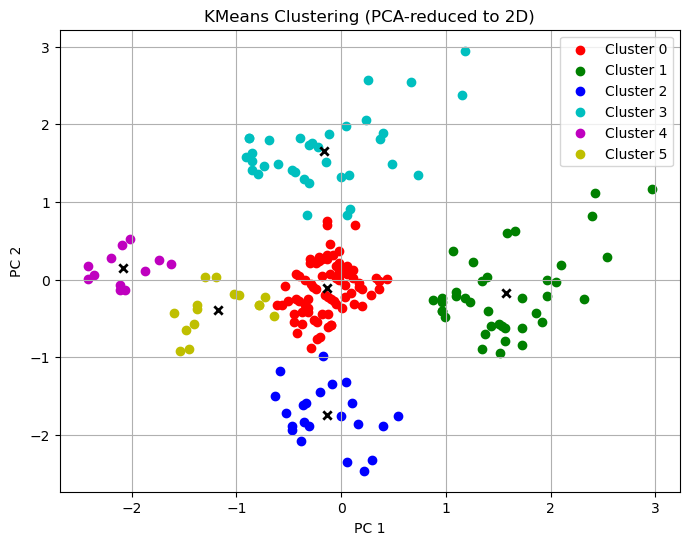

Scikit-learn KMeans converged in 5 iterations.


In [140]:
# Scikit-Learn KMeans
k = 6
sk_kmeans = SklearnKMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=42)
sk_kmeans.fit(X_scaled)

sk_centroids = sk_kmeans.cluster_centers_
sk_inertia = sk_kmeans.inertia_
sk_labels = sk_kmeans.labels_

clusters = [[] for _ in range(k)]
for i, label in enumerate(sk_labels):
    clusters[label].append(X_scaled[i])

plot_2D_clusters_with_pca(X_scaled, clusters, sk_centroids)
print(f"Scikit-learn KMeans converged in {sk_kmeans.n_iter_} iterations.")

Number of iterations (Kmean++): 7


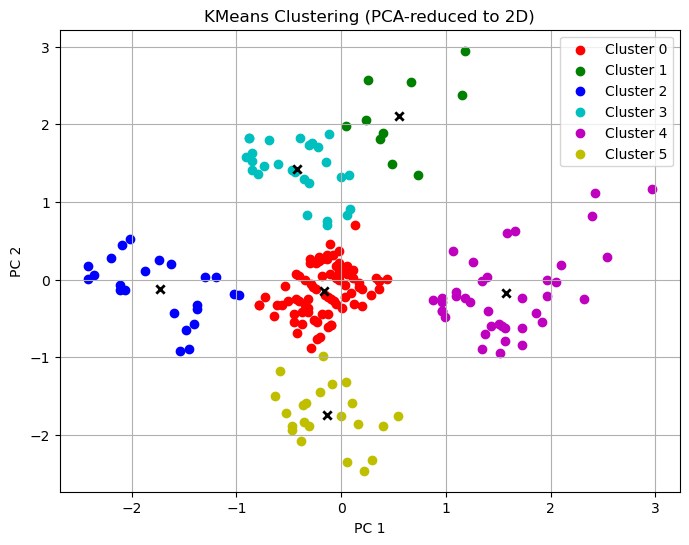

In [141]:
# Kmeans With Kmeans++ Initialzation
centroids,clusters,kmeans_plus_iter = Kmeans(X_scaled,K=6,
                                              max_iters=100,
                                              initialize_centroids_func=kmeans_plusplus_centroids_initialzation,
                                              random_state = 42)

print(f"Number of iterations (Kmean++): {kmeans_plus_iter}")
plot_2D_clusters_with_pca(X_scaled, clusters, centroids)

## **Step 16:** Conceptual Quiz

### **1. What is the objective function optimized in K-means?**

K-means minimizes the inertia, also known as the within-cluster sum of squares (WCSS):

$$
L = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
$$

Where
* $C_k$: cluster $k$
* $\mu_k$: centroid of cluster $k$
* $x_i$: a data point in cluster $k$

Hence assign each point to the nearest centroid such that the total distance between points and their assigned centroids is minimized.

### **2. Why can initialization affect the result?**

K-means uses a random starting point for centroids, and this can affect: Final clusters found or Convergence time.
For example:
* Poor initialization implies bad clustering even if it converges.
* Better initialization such as using K-Means++ improved performance and stability

### **3. How can we choose K without labels?**

You can use unsupervised model evaluation metrics such as:

* **1.Elbow Method**:Here we plot Inertia (WCSS) vs. K and we look for a elbow like point where adding more clusters doesn't significantly reduce inertia.

* **2.Silhouette Score**:It measures how similar a point is to its own cluster compared to other clusters.It ranges from -1 to 1. Here we pick K that gives the highest silhouette score.

### **4. When does K-means fail?**

K-means can fail or perform poorly in these situations:

* 1. Clusters are not spherical / convex or overlapping clusters.

* 2. Outliers present: Outliers distort centroids since K-means is sensitive to mean-based shifts.

* 3. Categorical data: Euclidean distance is not meaningful on categorical data like "Gender" especialy without proper encoding.

* 4. Poor initialization